## NYC Taxi Dataset Analysis using Time Series

In [1]:
import numpy as np
import pandas as pd
# from lstm_functions import WindowGenerator
from fft_utils import FFTFeatureExtractor
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [6]:
# NYC taxi dataset
train_df = pd.read_csv('../sample-data/train/train.csv')
test_df = pd.read_csv('../sample-data/test/test.csv')

# converting into datetime objects, and changing into boolean objects
train_df.pickup_datetime = pd.to_datetime(train_df.pickup_datetime)
train_df.dropoff_datetime = pd.to_datetime(train_df.dropoff_datetime)
train_df.dropoff_datetime = pd.to_datetime(train_df.dropoff_datetime)
train_df.store_and_fwd_flag = train_df.store_and_fwd_flag.apply(lambda x: 1 if x=='Y' else 0)

# creating new df ts_train based on minute resampling, creating elapsed time in mins and seconds
ts_train = train_df.groupby(pd.Grouper(key='pickup_datetime', freq='T'))[['passenger_count','trip_duration']].sum().reset_index()
ts_train['elapsed_time_min'] = (ts_train['pickup_datetime'] - min(ts_train['pickup_datetime'])).dt.total_seconds()/60
ts_train['elapsed_time_sec'] = (ts_train['pickup_datetime'] - min(ts_train['pickup_datetime'])).dt.total_seconds()

date_time = ts_train.pop('pickup_datetime')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60

# adding in features that reflect the daily seasonality like sin and cos transformations of timestamps during the day, 
# standardizing pass count, and trip duration
ts_train['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
ts_train['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
ts_train['pass_count_standardized'] = (ts_train['passenger_count'] - np.mean(ts_train['passenger_count'])) / np.std(ts_train['passenger_count'])
# removing any anomalies in the trip times
ts_train['trip_duration_truncated'] = ts_train.trip_duration.apply(lambda x: min(14000, x))
ts_train['trip_duration_std'] = (ts_train.trip_duration_truncated - np.mean(ts_train.trip_duration_truncated)) / np.std(ts_train.trip_duration_truncated)
ts_train.head()

,passenger_count,trip_duration,elapsed_time_min,elapsed_time_sec,day_sin,day_cos,pass_count_standardized,trip_duration_truncated,trip_duration_std
0,6,2143,0.0,0.0,-2.008887e-10,1.000000,-0.495907,2143,-0.739953
1,11,3454,1.0,60.0,2.588190e-01,0.965926,0.263713,3454,-0.359686
2,2,1755,2.0,120.0,5.000000e-01,0.866025,-1.103604,1755,-0.852496
3,3,2417,3.0,180.0,7.071068e-01,0.707107,-0.951680,2417,-0.660477
4,8,1291,4.0,240.0,8.660254e-01,0.500000,-0.192059,1291,-0.987083


## FFT Feature Addition

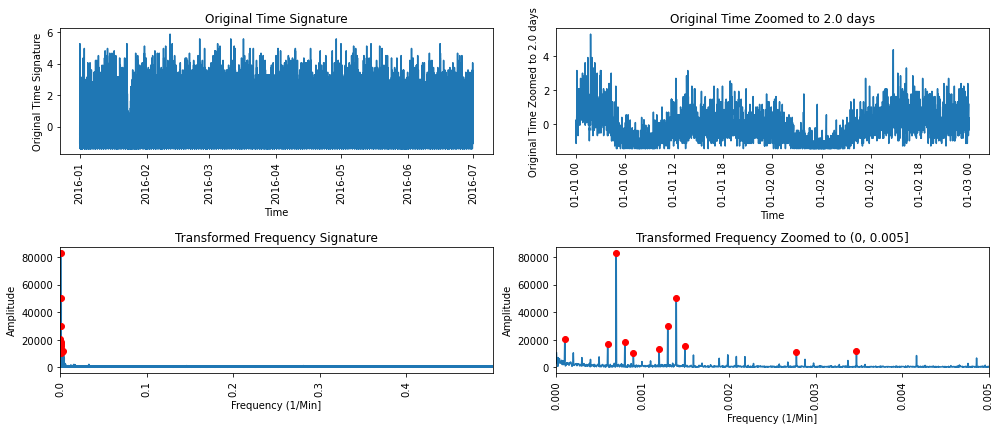

In [8]:
fftExtract = FFTFeatureExtractor(ts_train['pass_count_standardized'], time_series=date_time)
# plotting the FFT time and freq signatures, the left graphs show the total time and freq signatures, 
# while the right graphs show the zoomed in versions
fftExtract.fft_transform(freqlim_max=.005, timelim_max=48*60)

In [23]:
# capturing the top frequencies
freq_table = fftExtract.frequency_table_viewer()
# METHOD 1: capturing the time-domain signature that represents the FT_All combined feature, 
# however the amplitude is much smaller than manual FT_All method
filtered_residuals = fftExtract.ifft_transform()

# METHOD 2: converting the individual top frequencies into time signatures using T = 2*pi*f/60
fourier_table = fftExtract.fourier_terms_df_creator()
decomposedResult = fftExtract.decompose_df_into_pure_freq(signal=ts_train['pass_count_standardized'], time_min= ts_train['elapsed_time_min']  )
decomposedResult['FT_All_Std'] = (decomposedResult['FT_All'] - np.mean(decomposedResult['FT_All'])) / np.std(decomposedResult['FT_All'])
decomposedResult['pass_count_std-FT_All_Std'] = (decomposedResult['pass_count_standardized'] - decomposedResult['FT_All_Std'])

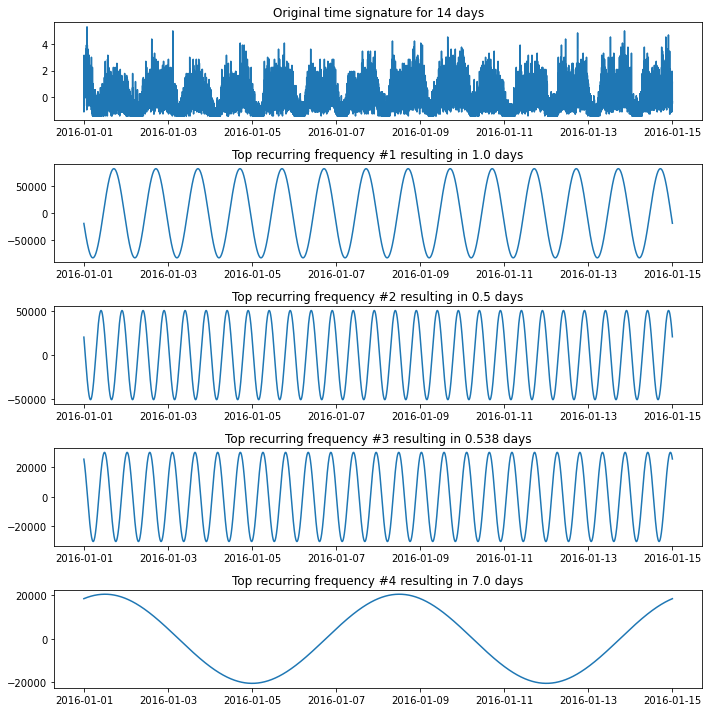

In [46]:
num_days = 14
plt.figure(figsize=(10,10))
ax1 = plt.subplot(5,1,1)
plt.plot(date_time[:60*24*num_days], ts_train['pass_count_standardized'][:60*24*num_days])
plt.title('Original time signature for {} days'.format(num_days))

for plot_num in range(2,6):
    ax1 = plt.subplot(5,1,plot_num)
    plt.plot(date_time[:60*24*num_days], decomposedResult['FT_{}'.format(plot_num - 1)][:60*24*num_days])
    plt.title('Top recurring frequency #{} resulting in {} days'.format(plot_num -1, np.round(freq_table['period (days)'].values[plot_num - 2], 3)))

plt.tight_layout()

In [49]:
gold_train_table = decomposedResult.merge(ts_train, left_on=['time_min', 'pass_count_standardized'], right_on=['elapsed_time_min', 'pass_count_standardized'])
gold_train_table.head()

,pass_count_standardized,time_min,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,FT_8,...,FT_All_Std,pass_count_std-FT_All_Std,passenger_count,trip_duration,elapsed_time_min,elapsed_time_sec,day_sin,day_cos,trip_duration_truncated,trip_duration_std
0,-0.495907,0.0,-19025.269777,20353.750914,25628.566729,18367.142717,11904.160193,7611.043881,-13298.138668,-10193.657445,...,0.400026,-0.895933,6,2143,0.0,0.0,-2.008887e-10,1.000000,2143,-0.739953
1,0.263713,1.0,-19378.179612,19950.007706,25497.732054,18372.680000,11972.347514,7554.763719,-13229.152571,-10255.000952,...,0.388426,-0.124713,11,3454,1.0,60.0,2.588190e-01,0.965926,3454,-0.359686
2,-1.103604,2.0,-19730.720514,19544.745228,25365.223113,18378.210145,12040.237123,7498.377884,-13159.009961,-10315.770692,...,0.376811,-1.480415,2,1755,2.0,120.0,5.000000e-01,0.866025,1755,-0.852496
3,-0.951680,3.0,-20082.885773,19137.994341,25231.048607,18383.733149,12107.827330,7441.887166,-13087.716972,-10375.963266,...,0.365181,-1.316861,3,2417,3.0,180.0,7.071068e-01,0.707107,2417,-0.660477
4,-0.192059,4.0,-20434.668681,18729.786022,25095.217345,18389.249010,12175.116457,7385.292354,-13015.279836,-10435.575306,...,0.353538,-0.545597,8,1291,4.0,240.0,8.660254e-01,0.500000,1291,-0.987083


In [50]:
train_df = gold_train_table[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std']][:int(0.7*len(decomposedResult))]
val_df = gold_train_table[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std']][int(0.7*len(decomposedResult)):int(0.85*len(decomposedResult))]
test_df = gold_train_table[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std']][int(0.85*len(decomposedResult)):]

We will try to predict number of passengers here based on these other features, and later introduce categorical features to check on accuracies. 

## Traditional VARMA for Multivariate Forecasting 

In [8]:
OUT_STEPS=10
num_features=5

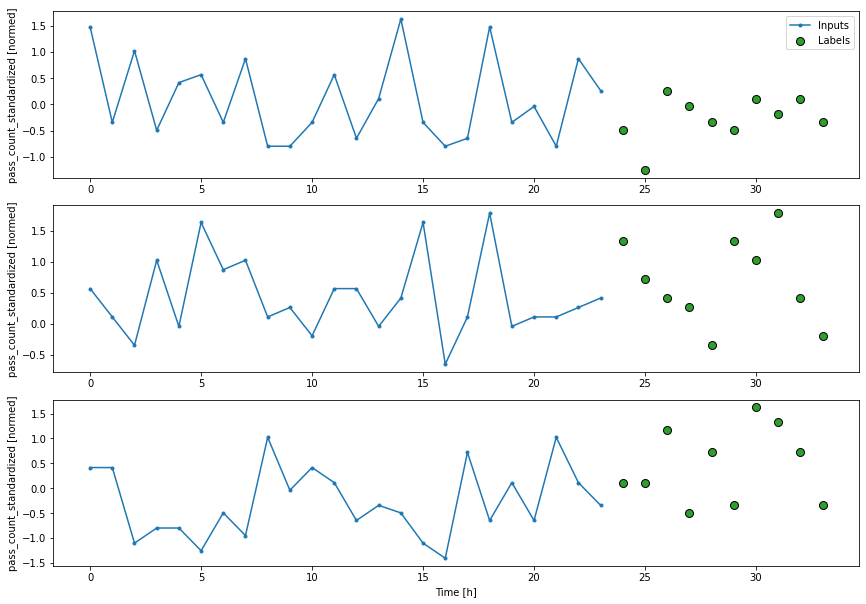

In [10]:
# need to first check on stationarity
multi_window = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS, train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['pass_count_standardized'])
multi_window.plot()

In [98]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2, learning_rate=0.001):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [12]:
multi_val_performance = dict()
multi_performance = dict()

Epoch 1/10
5732/5732 [==============================] - 15s 3ms/step - loss: 0.6430 - mean_absolute_error: 0.6123 - val_loss: 0.6139 - val_mean_absolute_error: 0.6012
Epoch 2/10
5732/5732 [==============================] - 13s 2ms/step - loss: 0.6373 - mean_absolute_error: 0.6085 - val_loss: 0.6128 - val_mean_absolute_error: 0.6023
Epoch 3/10
5732/5732 [==============================] - 13s 2ms/step - loss: 0.6365 - mean_absolute_error: 0.6080 - val_loss: 0.6123 - val_mean_absolute_error: 0.5998
Epoch 4/10
5732/5732 [==============================] - 15s 3ms/step - loss: 0.6359 - mean_absolute_error: 0.6077 - val_loss: 0.6134 - val_mean_absolute_error: 0.6028
Epoch 5/10
5732/5732 [==============================] - 12s 2ms/step - loss: 0.6355 - mean_absolute_error: 0.6075 - val_loss: 0.6112 - val_mean_absolute_error: 0.6021
Epoch 6/10
5732/5732 [==============================] - 13s 2ms/step - loss: 0.6353 - mean_absolute_error: 0.6074 - val_loss: 0.6131 - val_mean_absolute_error: 0.604

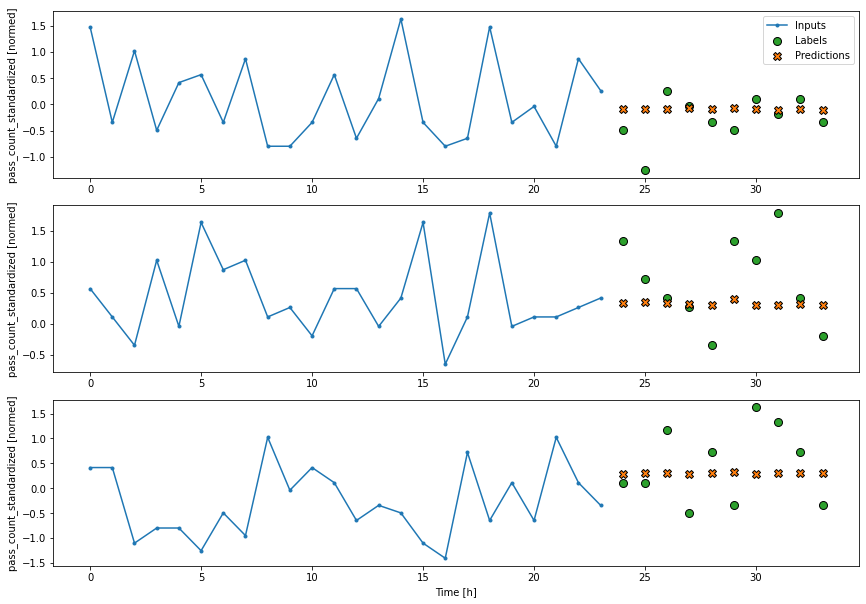

In [13]:
# Dense
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

# IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

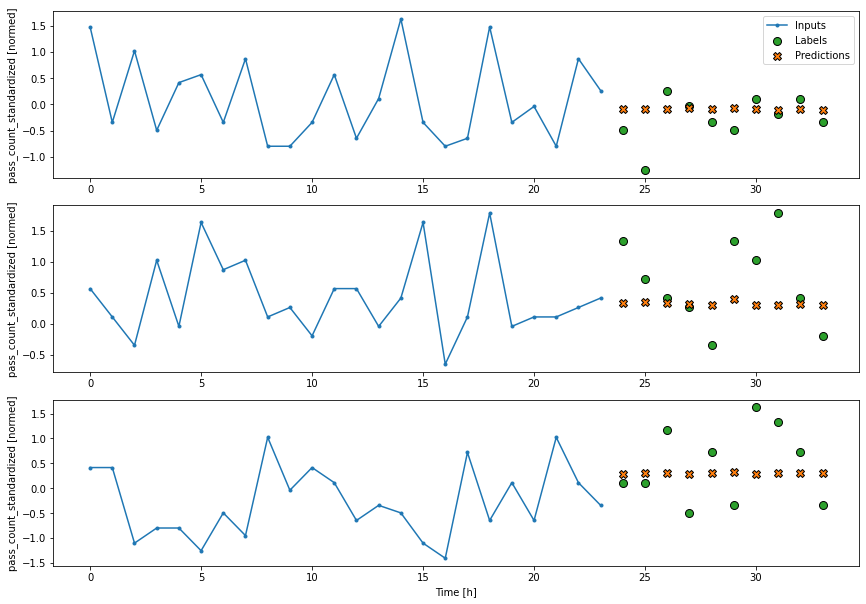

In [16]:
multi_window.plot(multi_dense_model)

Epoch 1/10
5732/5732 [==============================] - 50s 9ms/step - loss: 0.6096 - mean_absolute_error: 0.5931 - val_loss: 0.5878 - val_mean_absolute_error: 0.5884
Epoch 2/10
5732/5732 [==============================] - 41s 7ms/step - loss: 0.6028 - mean_absolute_error: 0.5885 - val_loss: 0.5865 - val_mean_absolute_error: 0.5890
Epoch 3/10
5732/5732 [==============================] - 41s 7ms/step - loss: 0.6019 - mean_absolute_error: 0.5880 - val_loss: 0.5867 - val_mean_absolute_error: 0.5880
Epoch 4/10
1228/1228 [==============================] - 3s 2ms/step - loss: 0.5868 - mean_absolute_error: 0.5859


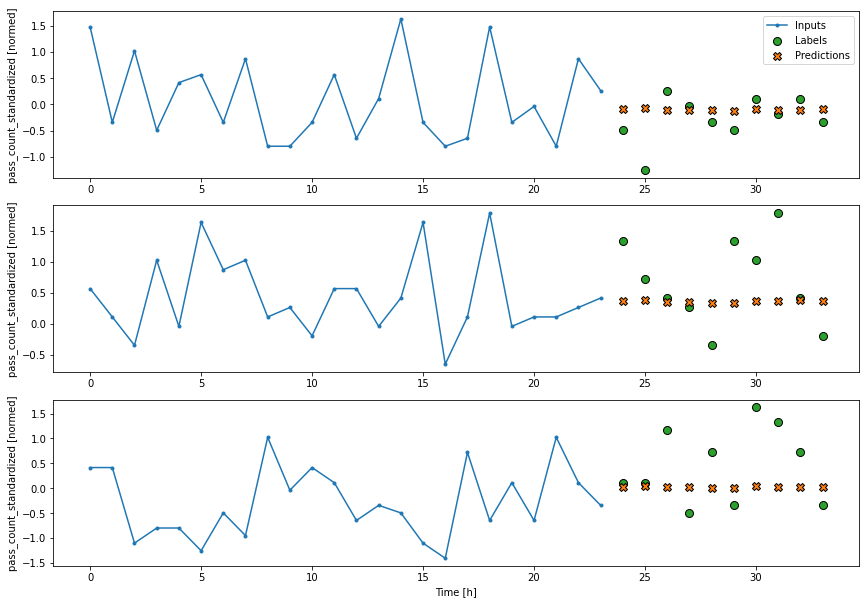

In [15]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(16, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [24]:
gold_train_table_ARIMA = gold_train_table.copy()

In [162]:
gold_train_table_ARIMA['pass_count_standardized_AR1'] = gold_train_table_ARIMA['pass_count_standardized'].shift(1).fillna(method='backfill')
gold_train_table_ARIMA['pass_count_standardized_AR2'] = gold_train_table_ARIMA['pass_count_standardized'].shift(2).fillna(method='backfill')
gold_train_table_ARIMA['pass_count_standardized_MA5'] = gold_train_table_ARIMA['pass_count_standardized'].rolling(5, center=True).mean().fillna(method='backfill').fillna(method='ffill')

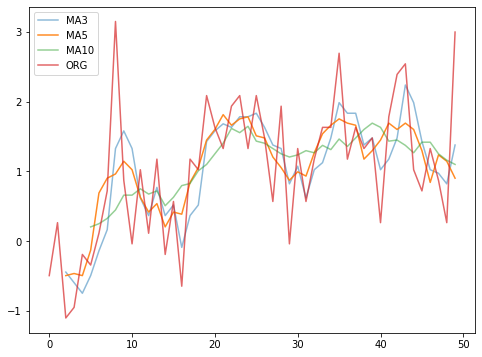

In [52]:
gold_train_table_ARIMA['pass_count_standardized'].rolling(3).mean().head(50).plot(label='MA3', alpha=0.5)
gold_train_table_ARIMA['pass_count_standardized'].rolling(5, center=True).mean().head(50).plot(label='MA5', alpha=0.9)
gold_train_table_ARIMA['pass_count_standardized'].rolling(10, center=True).mean().head(50).plot(label='MA10', alpha=0.5)
gold_train_table_ARIMA['pass_count_standardized'].head(50).plot(label='ORG', alpha=0.7)
plt.legend()

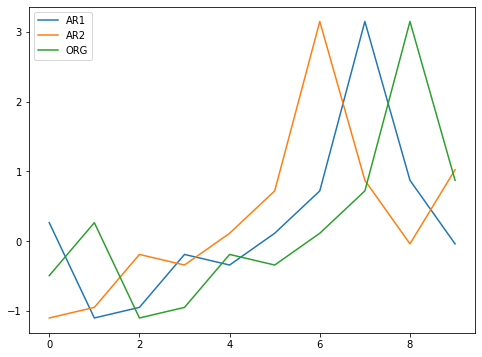

In [32]:
# gold_train_table_ARIMA['pass_count_standardized_AR1'] = 

gold_train_table_ARIMA['pass_count_standardized'].shift(-2).head(10).plot(label='AR2')
gold_train_table_ARIMA['pass_count_standardized'].head(10).plot(label='ORG')
plt.legend()

In [163]:
gold_train_table_ARIMA

,pass_count_standardized,time_min,FT_1,FT_2,FT_3,FT_4,FT_5,FT_6,FT_7,FT_8,...,passenger_count,trip_duration,time_sec,day_sin,day_cos,trip_duration_truncated,trip_duration_std,pass_count_standardized_AR1,pass_count_standardized_AR2,pass_count_standardized_MA5
0,-0.495907,0.0,-19025.269777,20353.750914,25628.566729,18367.142717,11904.160193,7611.043881,-13298.138668,-10193.657445,...,6,2143,0.0,-2.008887e-10,1.000000,2143,-0.739953,-0.495907,-0.495907,-0.495907
1,0.263713,1.0,-19378.179612,19950.007706,25497.732054,18372.680000,11972.347514,7554.763719,-13229.152571,-10255.000952,...,11,3454,60.0,2.588190e-01,0.965926,3454,-0.359686,-0.495907,-0.495907,-0.495907
2,-1.103604,2.0,-19730.720514,19544.745228,25365.223113,18378.210145,12040.237123,7498.377884,-13159.009961,-10315.770692,...,2,1755,120.0,5.000000e-01,0.866025,1755,-0.852496,0.263713,-0.495907,-0.495907
3,-0.951680,3.0,-20082.885773,19137.994341,25231.048607,18383.733149,12107.827330,7441.887166,-13087.716972,-10375.963266,...,3,2417,180.0,7.071068e-01,0.707107,2417,-0.660477,-1.103604,0.263713,-0.465523
4,-0.192059,4.0,-20434.668681,18729.786022,25095.217345,18389.249010,12175.116457,7385.292354,-13015.279836,-10435.575306,...,8,1291,240.0,8.660254e-01,0.500000,1291,-0.987083,-0.951680,-1.103604,-0.495907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262075,1.023333,262075.0,-17255.422012,22348.605949,26257.329299,18339.349298,11558.817503,7890.832107,-13625.513968,-9878.454662,...,16,8370,15724500.0,-9.659258e-01,0.258819,8370,1.066243,-0.495907,1.631030,0.537176
262076,0.567561,262076.0,-17610.075591,21952.917896,26134.992604,18344.922242,11628.467806,7835.092085,-13562.398852,-9942.614881,...,13,5824,15724560.0,-8.660254e-01,0.500000,5824,0.327754,1.023333,-0.495907,0.233328
262077,-0.040135,262077.0,-17964.393899,21555.558043,26010.939797,18350.488058,11697.828948,7779.242469,-13498.098091,-10006.218811,...,9,6750,15724620.0,-7.071068e-01,0.707107,6750,0.596348,0.567561,1.023333,0.354867
262078,0.111789,262078.0,-18318.370191,21156.556651,25885.179025,18356.046744,11766.899203,7723.284042,-13432.617306,-10069.262895,...,10,5893,15724680.0,-5.000000e-01,0.866025,5893,0.347768,-0.040135,0.567561,0.354867


In [164]:
train_df = gold_train_table_ARIMA[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std','pass_count_standardized_AR1','pass_count_standardized_AR2','pass_count_standardized_MA5']][:int(0.7*len(decomposedResult))]
val_df = gold_train_table_ARIMA[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std','pass_count_standardized_AR1','pass_count_standardized_AR2','pass_count_standardized_MA5']][int(0.7*len(decomposedResult)):int(0.85*len(decomposedResult))]
test_df = gold_train_table_ARIMA[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std','pass_count_standardized_AR1','pass_count_standardized_AR2','pass_count_standardized_MA5']][int(0.85*len(decomposedResult)):]

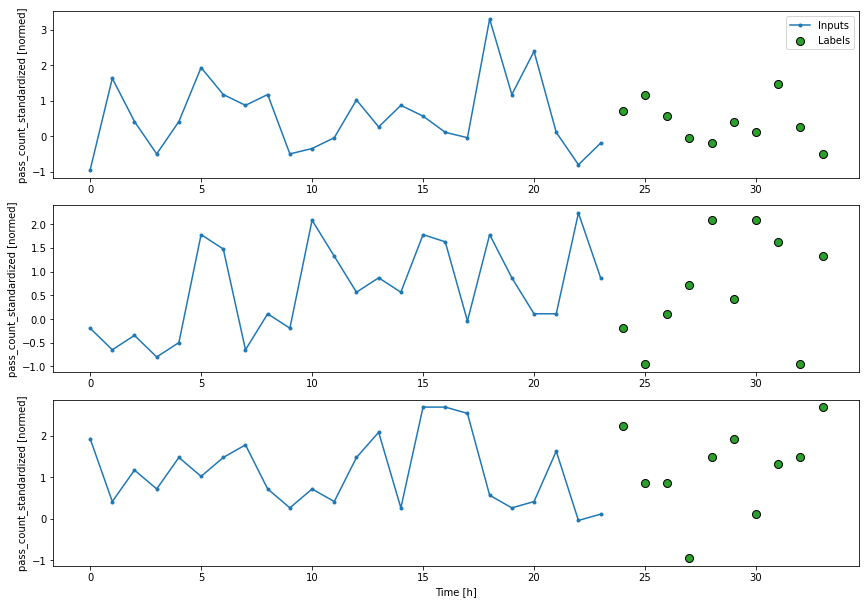

In [165]:
# need to first check on stationarity
multi_window = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS, train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['pass_count_standardized'])
multi_window.plot()

In [58]:
num_features=8

Epoch 1/10
5732/5732 [==============================] - 10s 2ms/step - loss: 0.5597 - mean_absolute_error: 0.5629 - val_loss: 0.5430 - val_mean_absolute_error: 0.5625
Epoch 2/10
5732/5732 [==============================] - 16s 3ms/step - loss: 0.5550 - mean_absolute_error: 0.5598 - val_loss: 0.5385 - val_mean_absolute_error: 0.5582
Epoch 3/10
5732/5732 [==============================] - 21s 4ms/step - loss: 0.5543 - mean_absolute_error: 0.5594 - val_loss: 0.5397 - val_mean_absolute_error: 0.5588
Epoch 4/10
1228/1228 [==============================] - 2s 2ms/step - loss: 0.5393 - mean_absolute_error: 0.5583


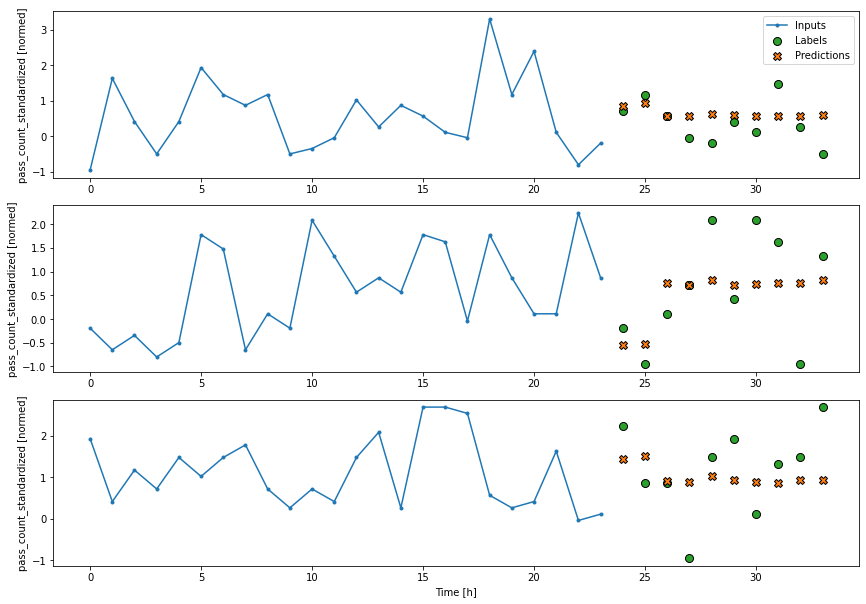

In [166]:
# Dense
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(24,8), name='input_layer'),
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])
history = compile_and_fit(multi_dense_model, multi_window)

# IPython.display.clear_output()
multi_val_performance['DenseAR+12MA5'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['DenseAR+12MA5'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

In [154]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2, learning_rate=0.001):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=learning_rate), #clipvalue=.5, clipnorm=1),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [172]:
OUT_STEPS=5

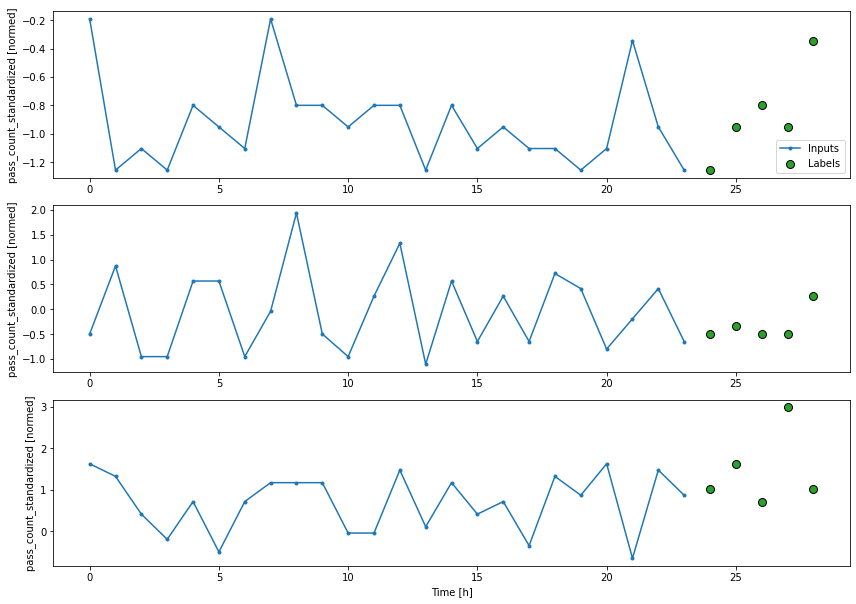

In [173]:
multi_window = WindowGenerator(
    input_width=24, label_width=OUT_STEPS, shift=OUT_STEPS, train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['pass_count_standardized'])
multi_window.plot()

Epoch 1/10
5733/5733 [==============================] - 51s 9ms/step - loss: 0.4445 - mean_absolute_error: 0.4634 - val_loss: 0.3548 - val_mean_absolute_error: 0.3721
Epoch 2/10
5733/5733 [==============================] - 51s 9ms/step - loss: 0.3718 - mean_absolute_error: 0.3924 - val_loss: 0.3534 - val_mean_absolute_error: 0.3690
Epoch 3/10
5733/5733 [==============================] - 52s 9ms/step - loss: 0.3702 - mean_absolute_error: 0.3901 - val_loss: 0.3527 - val_mean_absolute_error: 0.3682
Epoch 4/10
5733/5733 [==============================] - 63s 11ms/step - loss: 0.3695 - mean_absolute_error: 0.3890 - val_loss: 0.3521 - val_mean_absolute_error: 0.3656
Epoch 5/10
5733/5733 [==============================] - 62s 11ms/step - loss: 0.3690 - mean_absolute_error: 0.3883 - val_loss: 0.3519 - val_mean_absolute_error: 0.3657
Epoch 6/10
5733/5733 [==============================] - 56s 10ms/step - loss: 0.3685 - mean_absolute_error: 0.3877 - val_loss: 0.3525 - val_mean_absolute_error: 0.

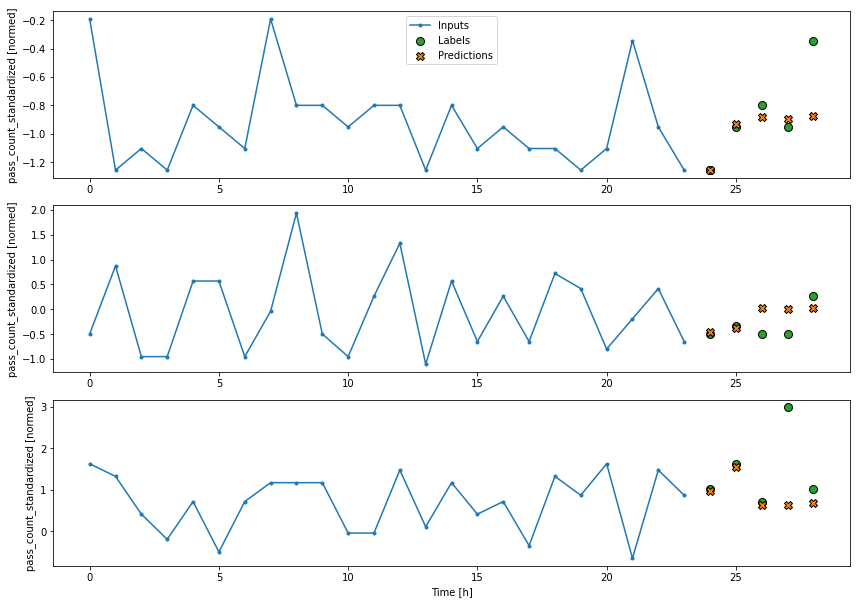

In [176]:
multi_lstm_model = tf.keras.Sequential([
    # tf.keras.layers.Input(shape=(24,num_features), name='input_layer'),
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Conv1D(8, kernel_size=6, strides=1, padding='valid', activation='relu'),
    # tf.keras.layers.Conv1D(16, kernel_size=2, strides=1, padding='valid', activation='relu'),
    # tf.keras.layers.SimpleRNN(32, return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(32, return_sequences=False, activation='tanh'),
    tf.keras.layers.Dropout(0.1),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features),
                        #   kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

# batch_input_shape=(32, 24, num_features), , stateful=True, , kernel_regularizer=tf.keras.regularizers.l2(.0001), activity_regularizer=tf.keras.regularizers.l2(0.00001),
history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

multi_val_performance['LSTMAR12MA5_conv1d_lstm_5_steps'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTMAR12MA5_conv1d_lstm_5_steps'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

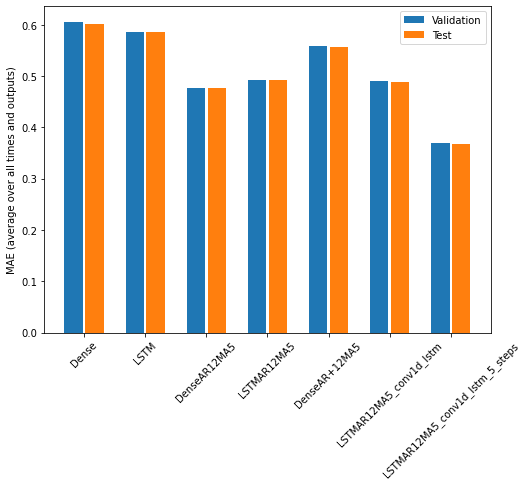

In [177]:
## Dense model works with nans associated with shift, but not LSTMs
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [87]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(183456, 8)
(39312, 8)
(39312, 8)


In [88]:
train_df = gold_train_table_ARIMA[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std','pass_count_standardized_AR1','pass_count_standardized_AR2','pass_count_standardized_MA5']].dropna()[:int(0.7*len(decomposedResult))]
val_df = gold_train_table_ARIMA[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std','pass_count_standardized_AR1','pass_count_standardized_AR2','pass_count_standardized_MA5']].dropna()[int(0.7*len(decomposedResult)):int(0.85*len(decomposedResult))]
test_df = gold_train_table_ARIMA[['pass_count_standardized', 'FT_All_Std','day_sin','day_cos','trip_duration_std','pass_count_standardized_AR1','pass_count_standardized_AR2','pass_count_standardized_MA5']].dropna()[int(0.85*len(decomposedResult)):]

In [89]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(183456, 8)
(39312, 8)
(39308, 8)


In [94]:
train_df.isnull()

,pass_count_standardized,FT_All_Std,day_sin,day_cos,trip_duration_std,pass_count_standardized_AR1,pass_count_standardized_AR2,pass_count_standardized_MA5
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
183453,False,False,False,False,False,False,False,False
183454,False,False,False,False,False,False,False,False
183455,False,False,False,False,False,False,False,False
183456,False,False,False,False,False,False,False,False
